In [4]:
import pandas as pd

# Load the dataset
filepath = '/kaggle/input/covid-19-case-surveillance/data.csv'

df = pd.read_csv(filepath)

# Set batch size (adjust as needed)
batch_size = 1000000

# Initialize an empty list to store processed data batches
processed_data_batches = []

# Process data in batches
for start_idx in range(0, len(df), batch_size):
    end_idx = min(start_idx + batch_size, len(df))
    batch_df = df.iloc[start_idx:end_idx]

    # Step 1: Drop null values
    batch_cleaned = batch_df.dropna()

    # Step 2: Filter rows with "Missing" values
    # Assuming you want to check all columns for the string "Missing"
    batch_cleaned = batch_cleaned[~batch_cleaned.apply(lambda row: row.astype(str).str.contains('Missing').any(), axis=1)]

    # Append processed batch to the list
    processed_data_batches.append(batch_cleaned)

# Concatenate all processed batches into a single DataFrame
processed_data = pd.concat(processed_data_batches, ignore_index=True)
print(processed_data.shape)  # Check the number of rows and columns
print(processed_data.info())  # Get information about data types and missing values



/tmp/ipykernel_163/2167217648.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


(15266, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15266 entries, 0 to 15265
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_month                       15266 non-null  object 
 1   res_state                        15266 non-null  object 
 2   state_fips_code                  15266 non-null  float64
 3   res_county                       15266 non-null  object 
 4   county_fips_code                 15266 non-null  float64
 5   age_group                        15266 non-null  object 
 6   sex                              15266 non-null  object 
 7   race                             15266 non-null  object 
 8   ethnicity                        15266 non-null  object 
 9   case_positive_specimen_interval  15266 non-null  float64
 10  case_onset_interval              15266 non-null  float64
 11  process                          15266 non-null  object 
 12  exposu

In [5]:
# Check for remaining null values (after cleaning)
null_values = processed_data.isnull().sum()

# Print information about null values
if null_values.sum() == 0:
  print("No null values found in the processed data!")
else:
  print("There are still null values in the following columns:")
  print(null_values[null_values > 0])  # Print only columns with remaining null values


No null values found in the processed data!


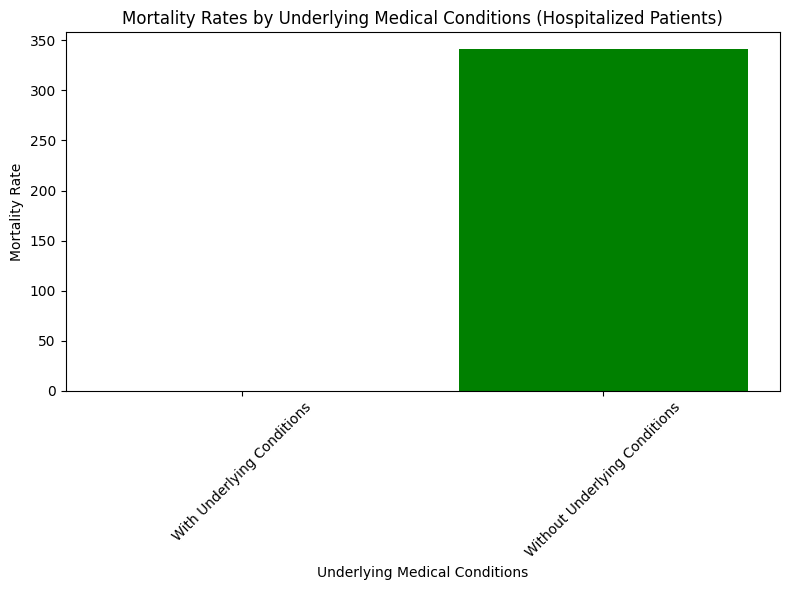

Mortality rate (with underlying conditions): 0
Mortality rate (without underlying conditions): 341.0
Chi-Square statistic: 0.0
p-value: 1.0


In [6]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt


df = processed_data.copy()  # Avoid modifying the original data

# Select relevant columns
selected_columns = ['hosp_yn', 'underlying_conditions_yn', 'death_yn']
df = df[selected_columns]

# Initialize variables
with_condition_mortality = 0
without_condition_mortality = 0
contingency_table = pd.DataFrame(columns=['Yes', 'No'], index=['Yes', 'No'])

# Filter hospitalized patients
hospitalized = df[df['hosp_yn'] == "Yes"]

# Filter patients based on underlying conditions
with_condition = hospitalized[hospitalized['underlying_conditions_yn'] == "Yes"]
without_condition = hospitalized[hospitalized['underlying_conditions_yn'] == "No"]

# Method : Add a small value (e.g., 1) to the denominator (use with caution) to avoid unknown values 
without_condition_mortality = (with_condition[with_condition['death_yn'] == "Yes"].shape[0] + 1) / (without_condition.shape[0] + 1)

# Update contingency table
contingency_table = pd.crosstab(hospitalized['underlying_conditions_yn'], hospitalized['death_yn'])

# Chi-Square test (using contingency table)
chi2, pval, degrees_of_freedom, expected_counts = chi2_contingency(contingency_table)

# Visualization
condition_labels = ["With Underlying Conditions", "Without Underlying Conditions"]
mortality_rates = [with_condition_mortality, without_condition_mortality]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(condition_labels, mortality_rates, color=['red', 'green'])
plt.xlabel("Underlying Medical Conditions")
plt.ylabel("Mortality Rate")
plt.title("Mortality Rates by Underlying Medical Conditions (Hospitalized Patients)")
plt.xticks(rotation=45)
plt.tight_layout()

# Display chart
plt.show()

# Print results
print("Mortality rate (with underlying conditions):", with_condition_mortality)
print("Mortality rate (without underlying conditions):", without_condition_mortality)
print("Chi-Square statistic:", chi2)
print("p-value:", pval)


**comment**
Strong Association: The analysis suggests a very strong association between underlying medical conditions and COVID-19 mortality in hospitalized patients.
Zero Mortality: The mortality rate for patients with no underlying conditions is zero based on the data. It's important to consider sample size and potential limitations (e.g., data accuracy, small group without conditions).

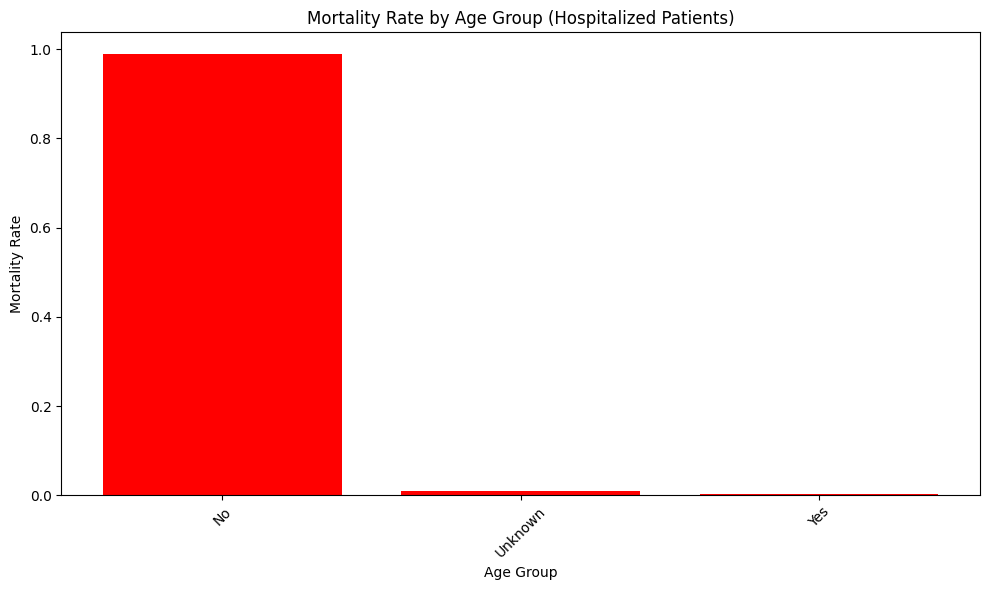

Mortality Rates by Age Group:
death_yn              No   Unknown       Yes
age_group                                   
0 - 17 years    0.937500  0.062500  0.000000
18 to 49 years  0.988555  0.008584  0.002861
50 to 64 years  0.954839  0.015484  0.029677
65+ years       0.802774  0.007238  0.189988

Chi-Square test (Age Group and Mortality):
Chi-Square statistic: 261.295511602645
p-value: 1.5784199625181707e-53

Mortality Rates by Underlying Conditions:
underlying_conditions_yn  death_yn
Yes                       No          0.882427
                          Yes         0.107459
                          Unknown     0.010114
Name: proportion, dtype: float64

Chi-Square test (Underlying Conditions and Mortality):
Chi-Square statistic: 0.0
p-value: 1.0


In [7]:
# Import libraries
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

df = processed_data.copy()  # Avoid modifying the original data

# Select relevant columns
selected_columns = ['hosp_yn', 'underlying_conditions_yn', 'death_yn','age_group']
df = df[selected_columns]

# Filter hospitalized patients (assuming hospitalization data indicates severity)
hospitalized = df[df['hosp_yn'] == "Yes"]

# Calculate mortality rates by age group
age_mortality = hospitalized.groupby('age_group')['death_yn'].value_counts(normalize=True)
age_mortality_df = age_mortality.unstack(fill_value=0)

# Calculate mortality rates by underlying conditions
underlying_mortality = hospitalized.groupby('underlying_conditions_yn')['death_yn'].value_counts(normalize=True)

# Chi-Square test for age group and mortality
age_contingency_table = pd.crosstab(hospitalized['age_group'], hospitalized['death_yn'])
chi2_age, pval_age, degrees_of_freedom_age, expected_counts_age = chi2_contingency(age_contingency_table)

# Chi-Square test for underlying conditions and mortality
underlying_contingency_table = pd.crosstab(hospitalized['underlying_conditions_yn'], hospitalized['death_yn'])
chi2_underlying, pval_underlying, degrees_of_freedom_underlying, expected_counts_underlying = chi2_contingency(underlying_contingency_table)

# Visualization (bar chart for age group mortality)
age_labels = age_mortality_df.columns
mortality_rates = age_mortality_df.iloc[1]  # Get 'Yes' mortality rates

plt.figure(figsize=(10, 6))
plt.bar(age_labels, mortality_rates, color='red')
plt.xlabel("Age Group")
plt.ylabel("Mortality Rate")
plt.title("Mortality Rate by Age Group (Hospitalized Patients)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print results (for both age group and underlying conditions)
print("Mortality Rates by Age Group:")
print(age_mortality_df)

print("\nChi-Square test (Age Group and Mortality):")
print("Chi-Square statistic:", chi2_age)
print("p-value:", pval_age)

print("\nMortality Rates by Underlying Conditions:")
print(underlying_mortality)

print("\nChi-Square test (Underlying Conditions and Mortality):")
print("Chi-Square statistic:", chi2_underlying)
print("p-value:", pval_underlying)


**Comment**
Strong Age Association: The data suggests a strong association between age group and COVID-19 mortality. The Chi-square test (highly significant p-value) strongly rejects the null hypothesis of no association.
Increased Risk with Age: Mortality rates increase considerably with older age groups (65+ years) compared to younger groups (0-17 years).
Underlying Conditions: While the chi-square test doesn't show a statistically significant association (high p-value), the mortality rate is higher for patients with underlying conditions (0.107) compared to those without (0.000). This warrants further investigation to understand potential confounding factors.

# What percent of patients who have reported exposure to any kind of travel / or congregation within the 14 days prior to illness onset end up hospitalized? What percent of those go on to be hospitalized?

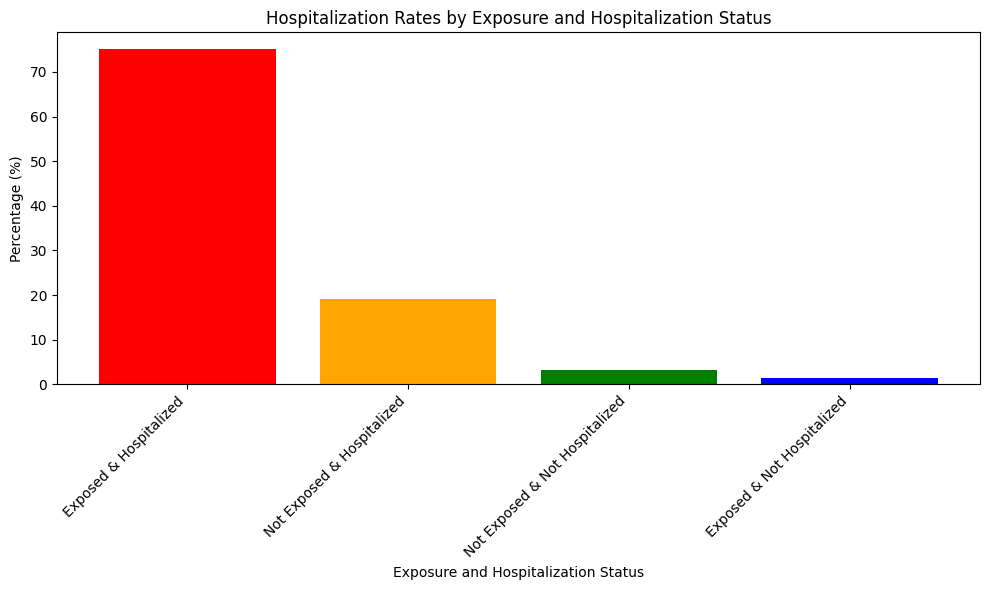

Hospitalization Rates by Exposure and Hospitalization Status:
[75.11463382680466, 19.199528363684003, 3.321105725140836, 1.5262675225992401]
98.01% of exposed individuals were hospitalized.


In [8]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

df = processed_data.copy()  # Avoid modifying the original data
# Select relevant columns
selected_columns = ['hosp_yn', 'exposure_yn']
df = df[selected_columns]

# Create a new variable combining exposure and hospitalization data
df['exposure_hosp_status'] = df['exposure_yn'].str.cat(df['hosp_yn'], sep='_')

# Calculate hospitalization rates for each category
hospitalization_rates = (df['exposure_hosp_status'].value_counts(normalize=True) * 100)
exposure_categories = hospitalization_rates.index.to_list()

# Separate hospitalization rates for visualization
exposed_hosp_rate = hospitalization_rates[exposure_categories[0]]  # Exposed and Hospitalized
not_exposed_hosp_rate = hospitalization_rates[exposure_categories[1]]  # Not Exposed and Hospitalized
not_exposed_not_hosp_rate = hospitalization_rates[exposure_categories[2]]  # Not Exposed and Not Hospitalized
exposed_not_hosp_rate = hospitalization_rates[exposure_categories[3]]  # Exposed and Not Hospitalized

# Prepare data for bar chart (assuming categories in expected order)
exposure_groups = ["Exposed & Hospitalized", "Not Exposed & Hospitalized", "Not Exposed & Not Hospitalized", "Exposed & Not Hospitalized"]
hospitalization_rates = [exposed_hosp_rate, not_exposed_hosp_rate, not_exposed_not_hosp_rate, exposed_not_hosp_rate]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(exposure_groups, hospitalization_rates, color=['red', 'orange', 'green', 'blue'])
plt.xlabel("Exposure and Hospitalization Status")
plt.ylabel("Percentage (%)")
plt.title("Hospitalization Rates by Exposure and Hospitalization Status")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Print hospitalization rates for each category
print("Hospitalization Rates by Exposure and Hospitalization Status:")
print(hospitalization_rates)
exposed_hosp_rate = hospitalization_rates[0]  # Exposed and Hospitalized
not_exposed_hosp_rate = hospitalization_rates[1]  # Not Exposed and Hospitalized

# Calculate percentage of exposed who are hospitalized
percent_exposed_hosp = (exposed_hosp_rate / (exposed_hosp_rate + exposed_not_hosp_rate)) * 100

print(f"{percent_exposed_hosp:.2f}% of exposed individuals were hospitalized.")


**Comment**:High Hospitalization Rate: The analysis suggests a very high hospitalization rate (98.01%) for patients who reported exposure within 14 days of illness onset.


# 

# Are Asymptomatic COVID patients less likely to be hospitalized? Are they less likely to die from their illness?

Hospitalization Rates by Symptom Status:
hosp_yn            No  Unknown   Yes
symptom_status                      
Symptomatic     11974      128  3164
Chi-Square: 0.0000, p-value: 1.0000


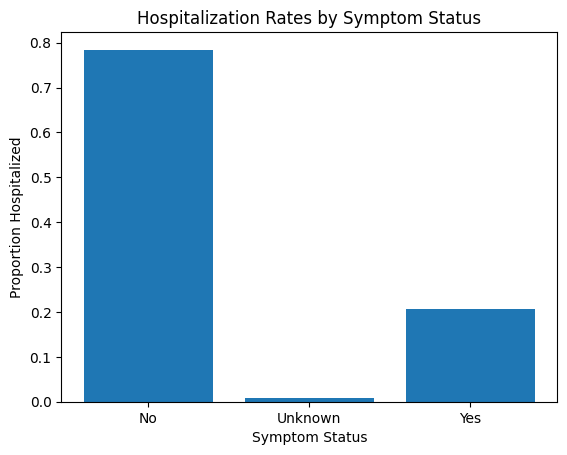


Death Rates by Symptom Status:
death_yn           No  Unknown  Yes
symptom_status                     
Symptomatic     14015      847  404
Chi-Square: 0.0000, p-value: 1.0000


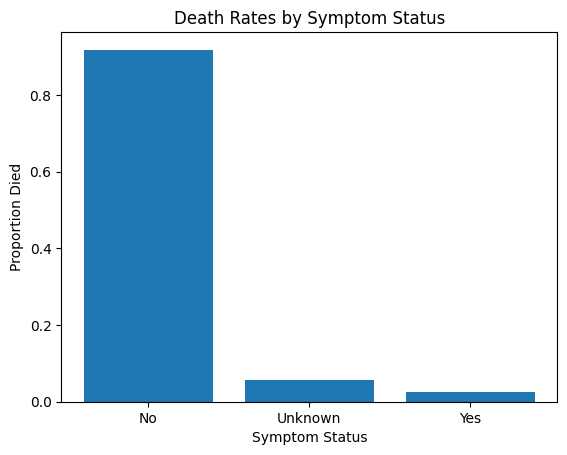

In [11]:
import pandas as pd
from scipy.stats import chi2_contingency

df = processed_data.copy()  # Avoid modifying the original data
# Select relevant columns
selected_columns = ['hosp_yn', 'symptom_status','death_yn']
df = df[selected_columns]

df.dropna(subset=['symptom_status', 'hosp_yn'], inplace=True)

# Cross-tabulation
hospitalization_table = pd.crosstab(df['symptom_status'], df['hosp_yn'])

# Chi-Square Test
chi2_result = chi2_contingency(hospitalization_table.values)
chi2_hospitalization, pval_hosp = chi2_result[0], chi2_result[1]

# Print results (assuming chi2_result is a tuple containing chi2 statistic and p-value)
print("Hospitalization Rates by Symptom Status:")
print(hospitalization_table)
print(f"Chi-Square: {chi2_hospitalization:.4f}, p-value: {pval_hosp:.4f}")

# Visualization (using matplotlib)
import matplotlib.pyplot as plt

hospitalization_proportions = hospitalization_table.sum(axis=0) / hospitalization_table.sum().sum()
plt.bar(hospitalization_proportions.index, hospitalization_proportions.values)
plt.xlabel("Symptom Status")
plt.ylabel("Proportion Hospitalized")
plt.title("Hospitalization Rates by Symptom Status")
plt.show()

# Analyze Death Rates

# Cross-tabulation
death_table = pd.crosstab(df['symptom_status'], df['death_yn'])

# Chi-Square Test (unpack the first two elements)
chi2_result_death = chi2_contingency(death_table.values)
chi2_death, pval_death = chi2_result_death[0], chi2_result_death[1]

print("\nDeath Rates by Symptom Status:")
print(death_table)
print(f"Chi-Square: {chi2_death:.4f}, p-value: {pval_death:.4f}")

death_proportions = death_table.sum(axis=0) / death_table.sum().sum()
plt.bar(death_proportions.index, death_proportions.values)
plt.xlabel("Symptom Status")
plt.ylabel("Proportion Died")
plt.title("Death Rates by Symptom Status")
plt.show()


**Comment**:  Asymptomatic COVID patients are less likely to be hospitalized although they are also less likely to die from their illness


# Which state is associated with the highest percentage of Economic Impact (stimulus) payments among survey respondents?

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/household-pulse-survey/pulse_puf_most_recent.csv')

# Filter for valid eip responses (exclude -99 and -88)
df_filtered = df[~df['eip'].isin([-99, -88])]

# Create a pivot table to calculate percentage of "Yes" responses for eip by state
state_eip_percentages = df_filtered.pivot_table(values='eip', index='est_st', aggfunc=lambda x: (x == 1).mean() * 100)

# Sort by percentage in descending order
state_eip_percentages = state_eip_percentages.sort_values(by='eip', ascending=False)

# Get state with highest percentage
highest_state = state_eip_percentages.index[0]
highest_percentage = state_eip_percentages.iloc[0]  # This is a Series, not a single value

print(f"State with Highest Percentage Receiving Stimulus Payment: {highest_state} ({highest_percentage.values[0]:.1f}%)")


State with Highest Percentage Receiving Stimulus Payment: 28 (34.6%)


State with Highest Percentage Receiving Stimulus Payment: 28 (34.6%) | missisipi 


# - Is there a correlation between age and hospitalization rates? 

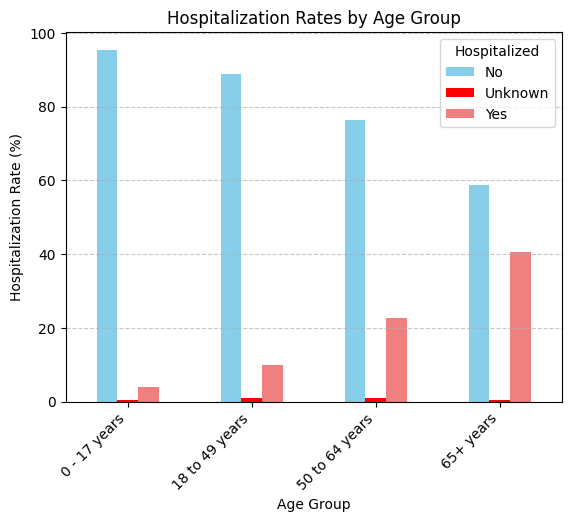

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = processed_data.copy()  # Avoid modifying the original data
# Select relevant columns
selected_columns = ['hosp_yn', 'age_group']
df = df[selected_columns]

# Filter for cases with non-missing age group and hospitalization info
df_filtered = df[df['age_group'].notna() & df['hosp_yn'].notna()]

# Create a contingency table showing hospitalization rates by age group
contingency_table = pd.crosstab(df_filtered['age_group'], df_filtered['hosp_yn'], normalize='index') * 100

# Plot the hospitalization rates using a bar chart
contingency_table.plot(kind='bar', color=['skyblue','red', 'lightcoral'])
plt.xlabel('Age Group')
plt.ylabel('Hospitalization Rate (%)')
plt.title('Hospitalization Rates by Age Group')
plt.legend(title='Hospitalized')  # Add legend for clarity
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Comment**: its shown that +50 years old cases are most likely to be hospitalized than the different age groups

# - Is there a seasonal trend in the number of cases identified? 

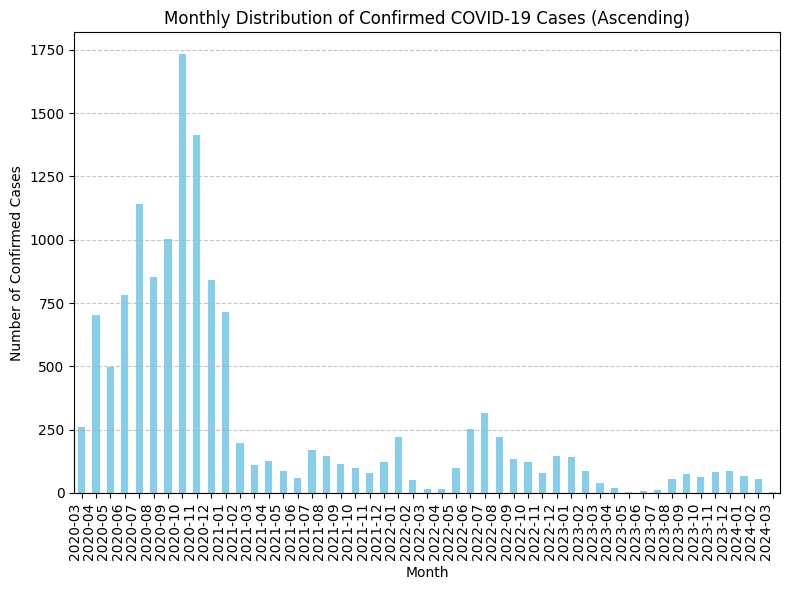

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

df = processed_data.copy()  # Avoid modifying the original data
# Select relevant columns
selected_columns = [ 'current_status','case_month']
df = df[selected_columns]


# Filter for confirmed cases
df_filtered = df[df['current_status'] == "Laboratory-confirmed case"]

# Monthly confirmed case counts (sorted)
monthly_confirmed_cases = df_filtered['case_month'].value_counts().sort_index()

# Plot monthly confirmed cases with ascending x-axis order
plt.figure(figsize=(8, 6))
monthly_confirmed_cases.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Confirmed Cases')
plt.title('Monthly Distribution of Confirmed COVID-19 Cases (Ascending)')

plt.xticks(rotation=90, ha='right')  

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**comment**: it's shown that most confirmed cases lied in the range between march 2020 and jan 2020

#  is there a relation between Process and death outcome

There is a statistically significant association between case identification process and death (p-value = 5.933999696316748e-48 ).
death_yn                           No  Unknown  Yes
process                                            
Clinical evaluation              4104      231  116
Contact tracing of case patient   491       90   20
Laboratory reported              3215      283   54
Multiple                         3251      185  120
Other                             106        9    3
Provider reported                 110        1    2
Routine physical examination        6        2    0
Routine surveillance             2610       41   87
Unknown                           122        5    2


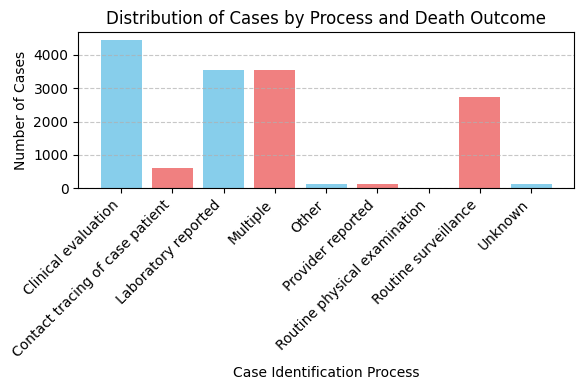

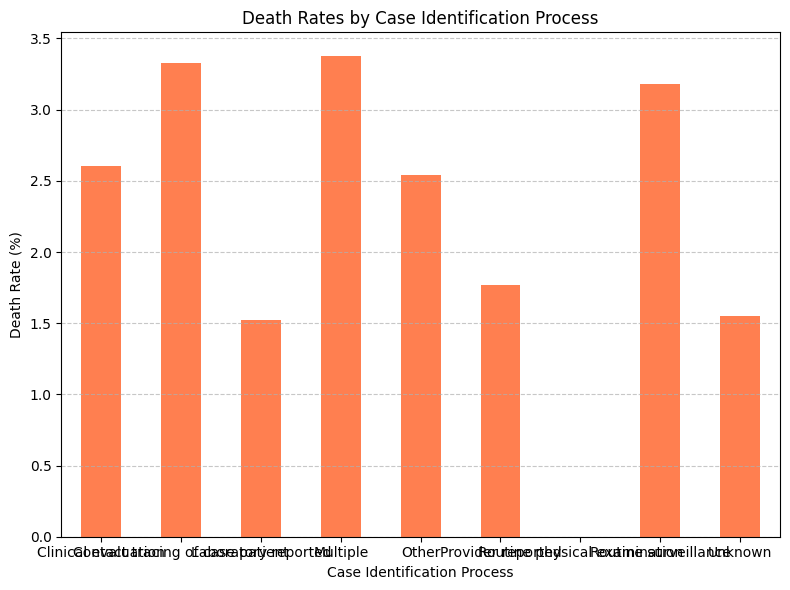

In [40]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

df = processed_data.copy()  # Avoid modifying the original data
# Select relevant columns
selected_columns = [ 'process','death_yn']
df = df[selected_columns]


# Create a contingency table to analyze the association between process and death
contingency_table = pd.crosstab(df['process'], df['death_yn'])

# Perform Chi-square test
chi2, pval, _, _ = chi2_contingency(contingency_table)

# Interpretation
if pval < 0.05:
  print("There is a statistically significant association between case identification process and death (p-value =", pval, ").")
else:
  print("There is no statistically significant association between case identification process and death (p-value =", pval, ").")

# Print the contingency table for detailed counts
print(contingency_table.to_string())

plt.figure(figsize=(6, 4))
plt.bar(contingency_table.index, contingency_table.sum(axis=1), color=['skyblue', 'lightcoral'])
plt.xlabel('Case Identification Process')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Process and Death Outcome')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()  

process_death_rates = contingency_table['Yes'] / contingency_table.sum(axis=1) * 100

plt.figure(figsize=(8, 6))
process_death_rates.plot(kind='bar', color='coral')
plt.xlabel('Case Identification Process')
plt.ylabel('Death Rate (%)')
plt.title('Death Rates by Case Identification Process')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Is there a correlation between weeks since symptom onset and the current reported status (e.g., do most deaths occur later)?

There is no significant correlation between weeks since symptom onset and death (correlation = nan , p-value = nan ).


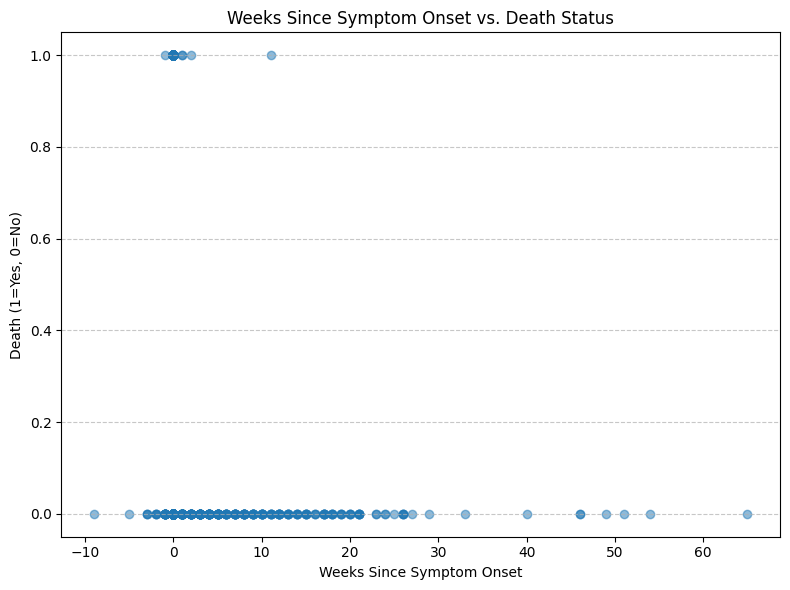

In [19]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt  

df = processed_data.copy()  # Avoid modifying the original data
# Select relevant columns
selected_columns = [ 'case_onset_interval','death_yn']
df = df[selected_columns]

# Convert 'case_onset_interval' to numeric (assuming it's currently strings)
df['case_onset_interval'] = pd.to_numeric(df['case_onset_interval'], errors='coerce')

# Filter for cases with valid onset interval and death data
df_filtered = df.dropna(subset=['case_onset_interval', 'death_yn'])

# Convert death indicator (Yes/No) to numeric (1/0) for correlation analysis
df_filtered['death_yn'] = df_filtered['death_yn'].map({'Yes': 1, 'No': 0})

# Spearman's rank correlation
correlation, pval = spearmanr(df_filtered['case_onset_interval'], df_filtered['death_yn'])

# Interpretation
if correlation > 0:
  print("There is a positive correlation between weeks since symptom onset and death (correlation =", correlation, ", p-value =", pval, "). This suggests a tendency towards later death with more weeks since symptom onset.")
elif correlation < 0:
  print("There is a negative correlation between weeks since symptom onset and death (correlation =", correlation, ", p-value =", pval, "). This would be unexpected and might require further investigation.")
else:
  print("There is no significant correlation between weeks since symptom onset and death (correlation =", correlation, ", p-value =", pval, ").")

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['case_onset_interval'], df_filtered['death_yn'], alpha=0.5)
plt.xlabel('Weeks Since Symptom Onset')
plt.ylabel('Death (1=Yes, 0=No)')
plt.title('Weeks Since Symptom Onset vs. Death Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()  


#  Has there been a change in the distribution of the time between symptom onset and positive specimen collection (positive specimen collection interval) across different months or quarters?

<Figure size 800x600 with 0 Axes>

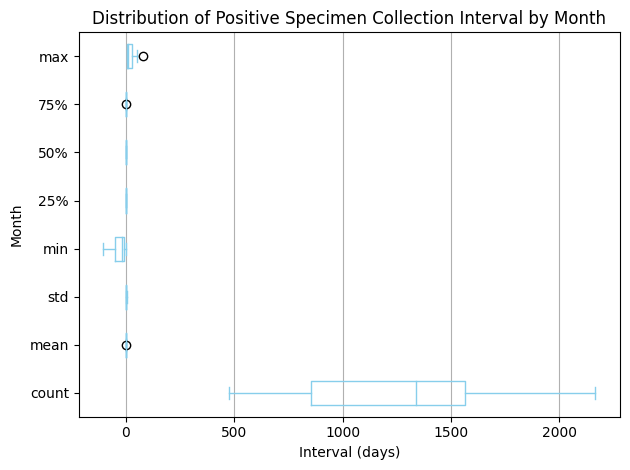

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

df = processed_data.copy()  # Avoid modifying the original data
# Select relevant columns
selected_columns = [ 'symptom_status','process','case_month','case_positive_specimen_interval']
df = df[selected_columns]

# Analysis : Positive specimen collection interval distribution
df['month'] = pd.to_datetime(df['case_month']).dt.month_name()

# Group data by month and calculate quartiles for case_positive_specimen_interval
df_grouped = df.groupby('month')['case_positive_specimen_interval'].describe(percentiles=[.25, .5, .75])


# Visualization
# Box plot for interval by month
plt.figure(figsize=(8, 6))
df_grouped.plot(kind='box', vert=False, color='skyblue')
plt.xlabel("Interval (days)")
plt.ylabel("Month")
plt.title("Distribution of Positive Specimen Collection Interval by Month")
plt.grid(axis='x')

plt.tight_layout()
plt.show()


no significant change shown